# Final Project Parts 4-7 Analysis

## Imports

In [33]:
from astropy.io import fits
import lmfit
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from scipy.signal import find_peaks, medfilt
from scipy.optimize import curve_fit
import pandas as pd
from matplotlib.colors import LogNorm
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
import re
from scipy.ndimage import gaussian_filter1d
from scipy.signal import correlate
from scipy.ndimage import median_filter
from collections import defaultdict

from astropy import units as u
from specutils import Spectrum, SpectralRegion
from specutils.analysis import equivalent_width, fwhm

from scipy.signal import find_peaks, savgol_filter
from scipy.interpolate import interp1d

from scipy.ndimage import center_of_mass, shift

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
%matplotlib widget  

## Functions

In [3]:
def collect_fits_files(directory):
    # containers
    rc_files = []
    reduced_files = []
    ref1_files = []
    ref2_files = []
    ref3_files = []
    toi_files = []
    full_files = []

    for fname in os.listdir(directory):
        if not fname.endswith(".fits"):
            continue

        # strip extension
        base = fname[:-5]

        if base.endswith("_rc"):
            rc_files.append(fname)
        elif base.endswith("_reduced"):
            reduced_files.append(fname)
        elif base.endswith("_ref1"):
            ref1_files.append(fname)
        elif base.endswith("_ref2"):
            ref2_files.append(fname)
        elif base.endswith("_ref3"):
            ref3_files.append(fname)
        elif base.endswith("_toi"):
            toi_files.append(fname)
        else:
            # no suffix → full / raw fits
            full_files.append(fname)

    # sort everything for consistency
    for lst in [rc_files, reduced_files, ref1_files, ref2_files, ref3_files, toi_files, full_files]:
        lst.sort()

    return {
        "rc": rc_files,
        "reduced": reduced_files,
        "ref1": ref1_files,
        "ref2": ref2_files,
        "ref3": ref3_files,
        "toi": toi_files,
        "full": full_files,
    }

## Filepaths

In [9]:
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, 'kaia_data')

fits_files = collect_fits_files(data_dir)
rc_fnames = fits_files['rc']
reduced_fnames = fits_files['reduced']
full_fnames = fits_files['full']
toi_fnames = fits_files['toi']
ref1_fnames = fits_files['ref1']
ref2_fnames = fits_files['ref2']
ref3_fnames = fits_files['ref3']

## Part 4) Bouguer's Law

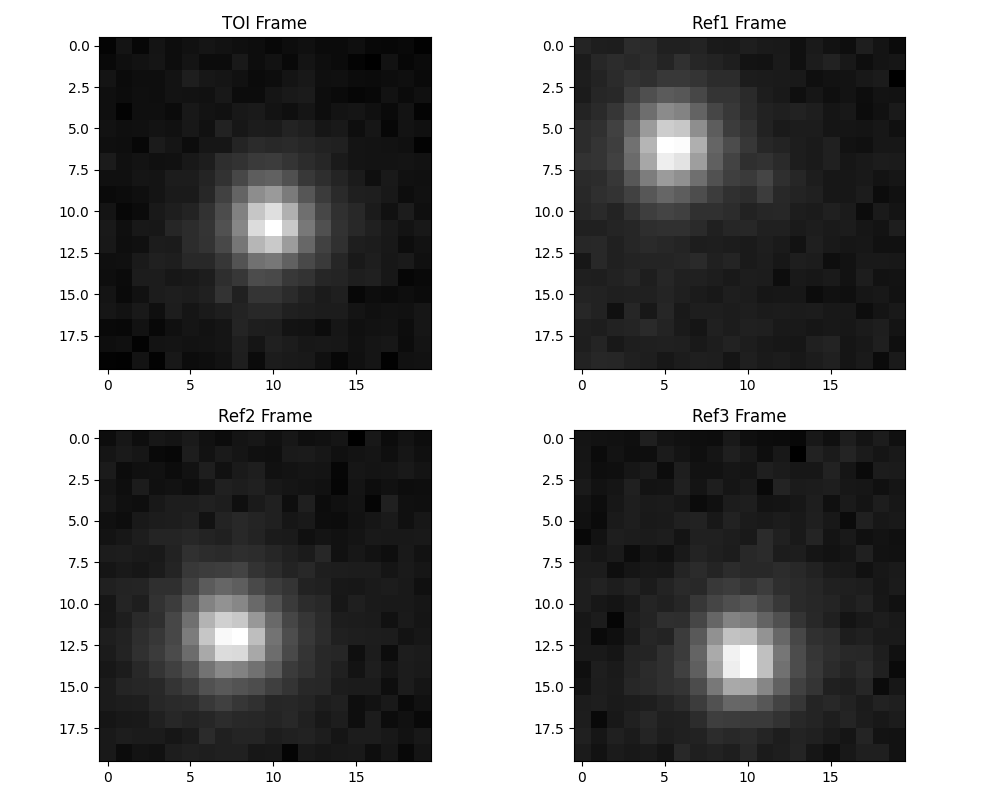

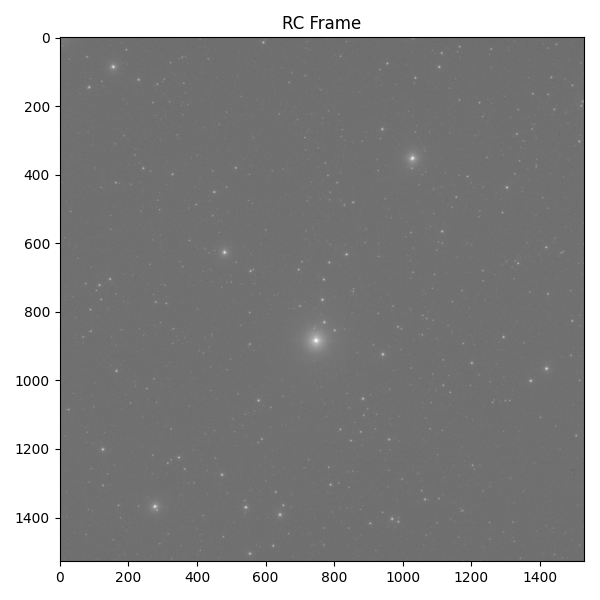

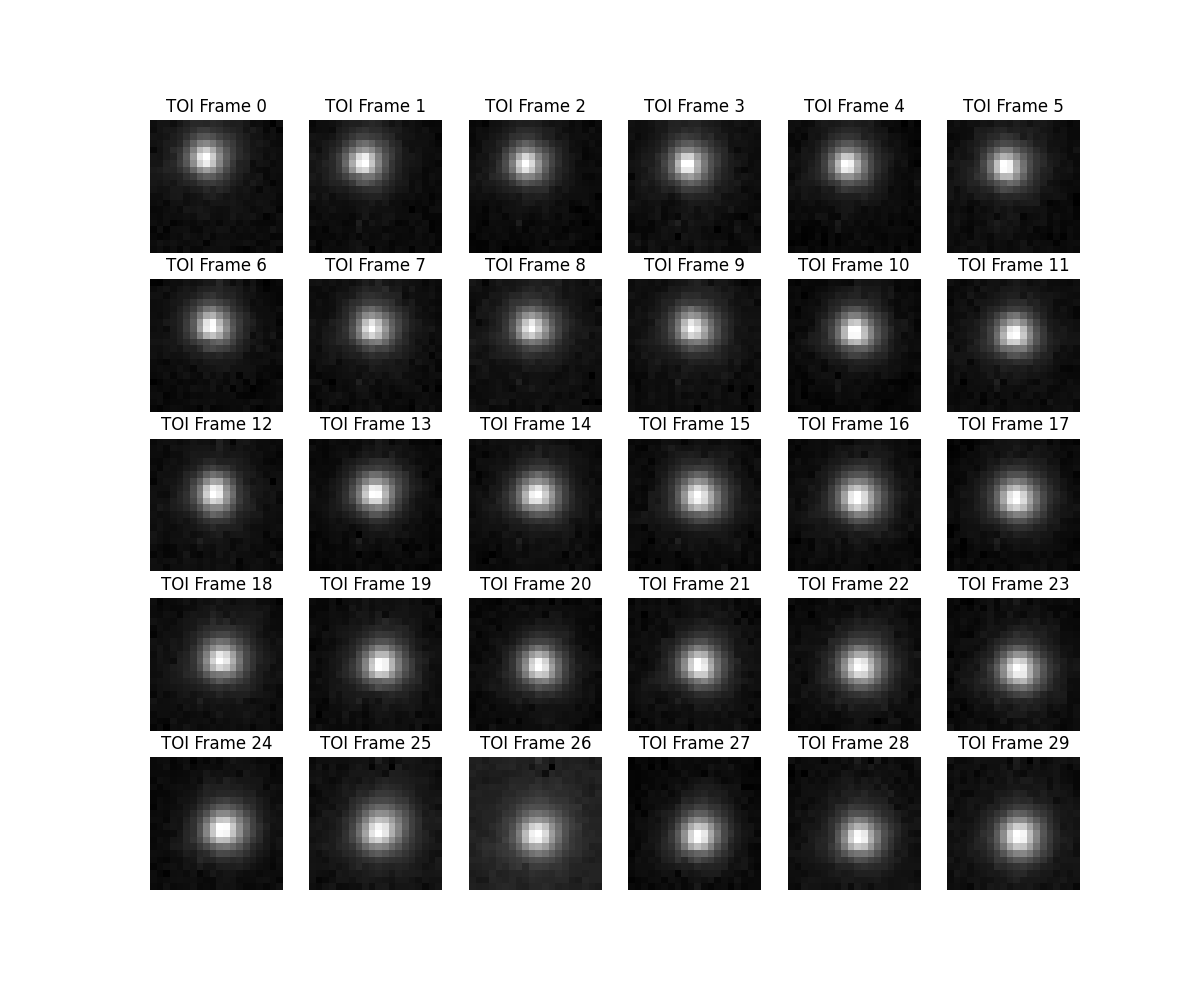

In [35]:
# start by just inspecting one of each type (only toi, ref1, ref2, ref3)
example_toi = fits.open(os.path.join(data_dir, toi_fnames[100]))
example_ref1 = fits.open(os.path.join(data_dir, ref1_fnames[100]))
example_ref2 = fits.open(os.path.join(data_dir, ref2_fnames[100]))
example_ref3 = fits.open(os.path.join(data_dir, ref3_fnames[100]))
example_rc = fits.open(os.path.join(data_dir, rc_fnames[100]))

# plot the data for visual inspection
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(example_toi[0].data, cmap='gray', norm=LogNorm())
axs[0, 0].set_title('TOI Frame')
axs[0, 1].imshow(example_ref1[0].data, cmap='gray', norm=LogNorm())
axs[0, 1].set_title('Ref1 Frame')
axs[1, 0].imshow(example_ref2[0].data, cmap='gray', norm=LogNorm())
axs[1, 0].set_title('Ref2 Frame')
axs[1, 1].imshow(example_ref3[0].data, cmap='gray', norm=LogNorm())
axs[1, 1].set_title('Ref3 Frame')
plt.tight_layout()

# separately plot the RC frame
plt.figure(figsize=(6, 6))
plt.imshow(example_rc[0].data, cmap='gray', norm=LogNorm())
plt.title('RC Frame')
plt.tight_layout()

# for just toi, plot first 30 frames
fig, axs = plt.subplots(5, 6, figsize=(12, 10))
for i in range(30):
    ax = axs[i // 6, i % 6]
    toi_frame = fits.open(os.path.join(data_dir, toi_fnames[i]))
    ax.imshow(toi_frame[0].data, cmap='gray', norm=LogNorm())
    ax.set_title(f'TOI Frame {i}')
    ax.axis('off')